# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add HyperbolicsLCS folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/HyperbolicLCS")

Wall time: 0 ns


In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Overview

In the following notebok we visualize the FTLE from AVISO data. The notebook is structured as follows:

1. Import data from the file 'Agulhas_AVISO.mat' stored in the folder 'data'
<br />
2. Define computational parameters (such as the number of cores) and data
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data
 <br />
5. Repelling LCS from forward computation:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid. 
    
    * Compute Cauchy Green (CG) strain tensor as: 
    
    \begin{equation} \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) = \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0)^T\mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0). \end{equation}
   
    * Compute maximum eigenvalues $ \lambda_2(\mathbf{x}_0) $ of $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $.
    
    * Compute repelling LCS (extracted over the time-interval $ [t_0, t_N] $) at time $ t_0 $ as tensorlines tangent to the eigenvector field $ \mathbf{\xi_1(\mathbf{x})} $ associated to the minimum eigenvalue $ \lambda_1(\mathbf{x}) $ of $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $:
    
    \begin{equation}
    \dfrac{d}{ds} \mathbf{x}(s) =  \mathbf{\xi_1(\mathbf{x})}
    \end{equation}
    
    * Compute attracting LCS (extracted over the time-interval $ [t_0, t_N] $) at time $ t_0 $ as tensorlines tangent to the eigenvector field $ \mathbf{\xi_2(\mathbf{x})} $ associated to the maximum eigenvalue $ \lambda_2(\mathbf{x}) $ of $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $:
    
    \begin{equation}
    \dfrac{d}{ds} \mathbf{x}(s) =  \mathbf{\xi_2(\mathbf{x})}
    \end{equation}
    
    Note that we compute repelling and attracting LCS from a single forward computation. Similarly repelling and attracting LCS can be computed from a single backward computation. Due to the unavoidable orientational discontinuities of the eigenvector-field, the integration has to be performed manually by checking the orientation of the eigenvector at every time-step. If the orientation is not equivalent to the orientation of the eigenvector at the previous step of integration, then the eigenvector has to be flipped before computing the integration step.

# Import data

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 22.9 ms


# Data/Parameters for dynamical system

In [4]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 8

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
# Spatio-temporal domain of dynamical system

In [5]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 20

# time step-size
dt = .1

# tN-t0
lenT = tN-t0

time = np.arange(t0, tN+dt, dt)

# domain boundary (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -28

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 0 ns


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [6]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time, method = "cubic")

Wall time: 70.9 ms


# Cauchy Green (CG) strain tensor

The Cauchy Green strain tensor $ C_{t_0}^t(\mathbf{x}) $ is computed by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{10}, \dfrac{1}{100}] $. The computations are parallelized.

In [7]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Import gradient of velocity function
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import Rate of Strain function
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/10, 1/100]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 5), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 5)]

# parallellized computation
def parallel_C(i):
    
    C_parallel = np.zeros((X_domain.shape[1], 2, 2))
    
    for j in range(C_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # only compute Cauchy Green strain tensor for trajectories starting in region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
        
            # Compute gradient of flowmap
            gradFmap = gradient_flowmap(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
            # gradFmap has shape (2, 2, len(time)) --> we need gradient of flow map from t0 to tN
            gradFmap_t0_tN = gradFmap[:,:,-1]
            
            # Compute CG tensor
            C_parallel[j, :, :] = CauchyGreen(gradFmap_t0_tN)
            
        else:
            
            C_parallel[j, :, :] = np.nan
    
    return C_parallel

C = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_C)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/201 [00:00<?, ?it/s]

Wall time: 2min 47s


# Eigenvalues/Eigenvectors of Cauchy Green strain tensor

We now compute the eigenvalues and eigenvectors of Cauchy Green strain tensor 'C'.

In [8]:
%%time
# Import eigenvalues/eigenvectors calculator
from ipynb.fs.defs.eigen import eigen

# maximum eigenvalues of CG-tensor
eig1 = C[:,:,0,0].copy()*np.nan
# minimum eigenvalues of CG-tensor
eig2 = C[:,:,0,0].copy()*np.nan
# eigenvectors associated to maximum eigenvalues of CG-tensor
e1 = np.zeros((C.shape[0], C.shape[1], 2))
# eigenvectors associated to minimum eigenvalues of CG-tensor
e2 = np.zeros((C.shape[0], C.shape[1], 2))

#iterate over meshgrid
for i in range(X_domain.shape[0]):
    
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute eigenvalues of rate of strain
        eig1[i,j], eig2[i,j], e1[i,j,:], e2[i,j,:] = eigen(C[i,j,:,:])

Wall time: 394 ms


# Shrinklines (Repelling LCS)

Repelling LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \xi_1(\mathbf{x}_0;t_0, t_N),
\label{eq: shrinklines}
\end{equation}

with $ \xi_1 $ denoting the eigenvector associated to the weakest eigenvalue $ \lambda_1 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most repelling shrinklines mark initial positions of repelling LCSs. Repelling LCSs can therefore be located as trajectories of eq. \ref{eq: shrinklines} that have locally the largest averaged $ \lambda_2(\mathbf{x}_0;t_0, t_N) $ among all neighbouring shrinklines.

In [9]:
%%time
from ipynb.fs.defs.tensorlines import _tensorlines

# step-size used for integration
step_size = 0.05

# threshold distance to locate local maxima in the 'eig2'
max_distance = 0.1

# maximum length of shrinkline
max_length = 5

# compute shrinklines
shrinklines = _tensorlines(X_domain, Y_domain, eig2, e1, max_distance, max_length, step_size)

Wall time: 5.29 s


# Stretchlines (Attracting LCS)

Attracting LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0 = \xi_2(\mathbf{x}_0;t_0, t_N),
\label{eq: stretchlines}
\end{equation}

with $ \xi_2 $ denoting the eigenvector associated to the strongest eigenvalue $ \lambda_2 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most attracting stretchlines mark initial positions of attracting LCSs. Attracting LCSs can therefore be located as trajectories of eq. \ref{eq: stretchlines} that have locally the smallest averaged $ \lambda_1(\mathbf{x}_0;t_0, t_N) $ among all neighbouring stretchlines.

In [10]:
from ipynb.fs.defs.tensorlines import _tensorlines

# step-size used for integration
step_size = 0.05

# threshold distance to locate local maxima in the 'eig2'
max_distance = 0.25

# maximum length of stretchline
max_length = 5

# compute stretchlines
stretchlines = _tensorlines(X_domain, Y_domain, eig2, e2, max_distance, max_length, step_size)

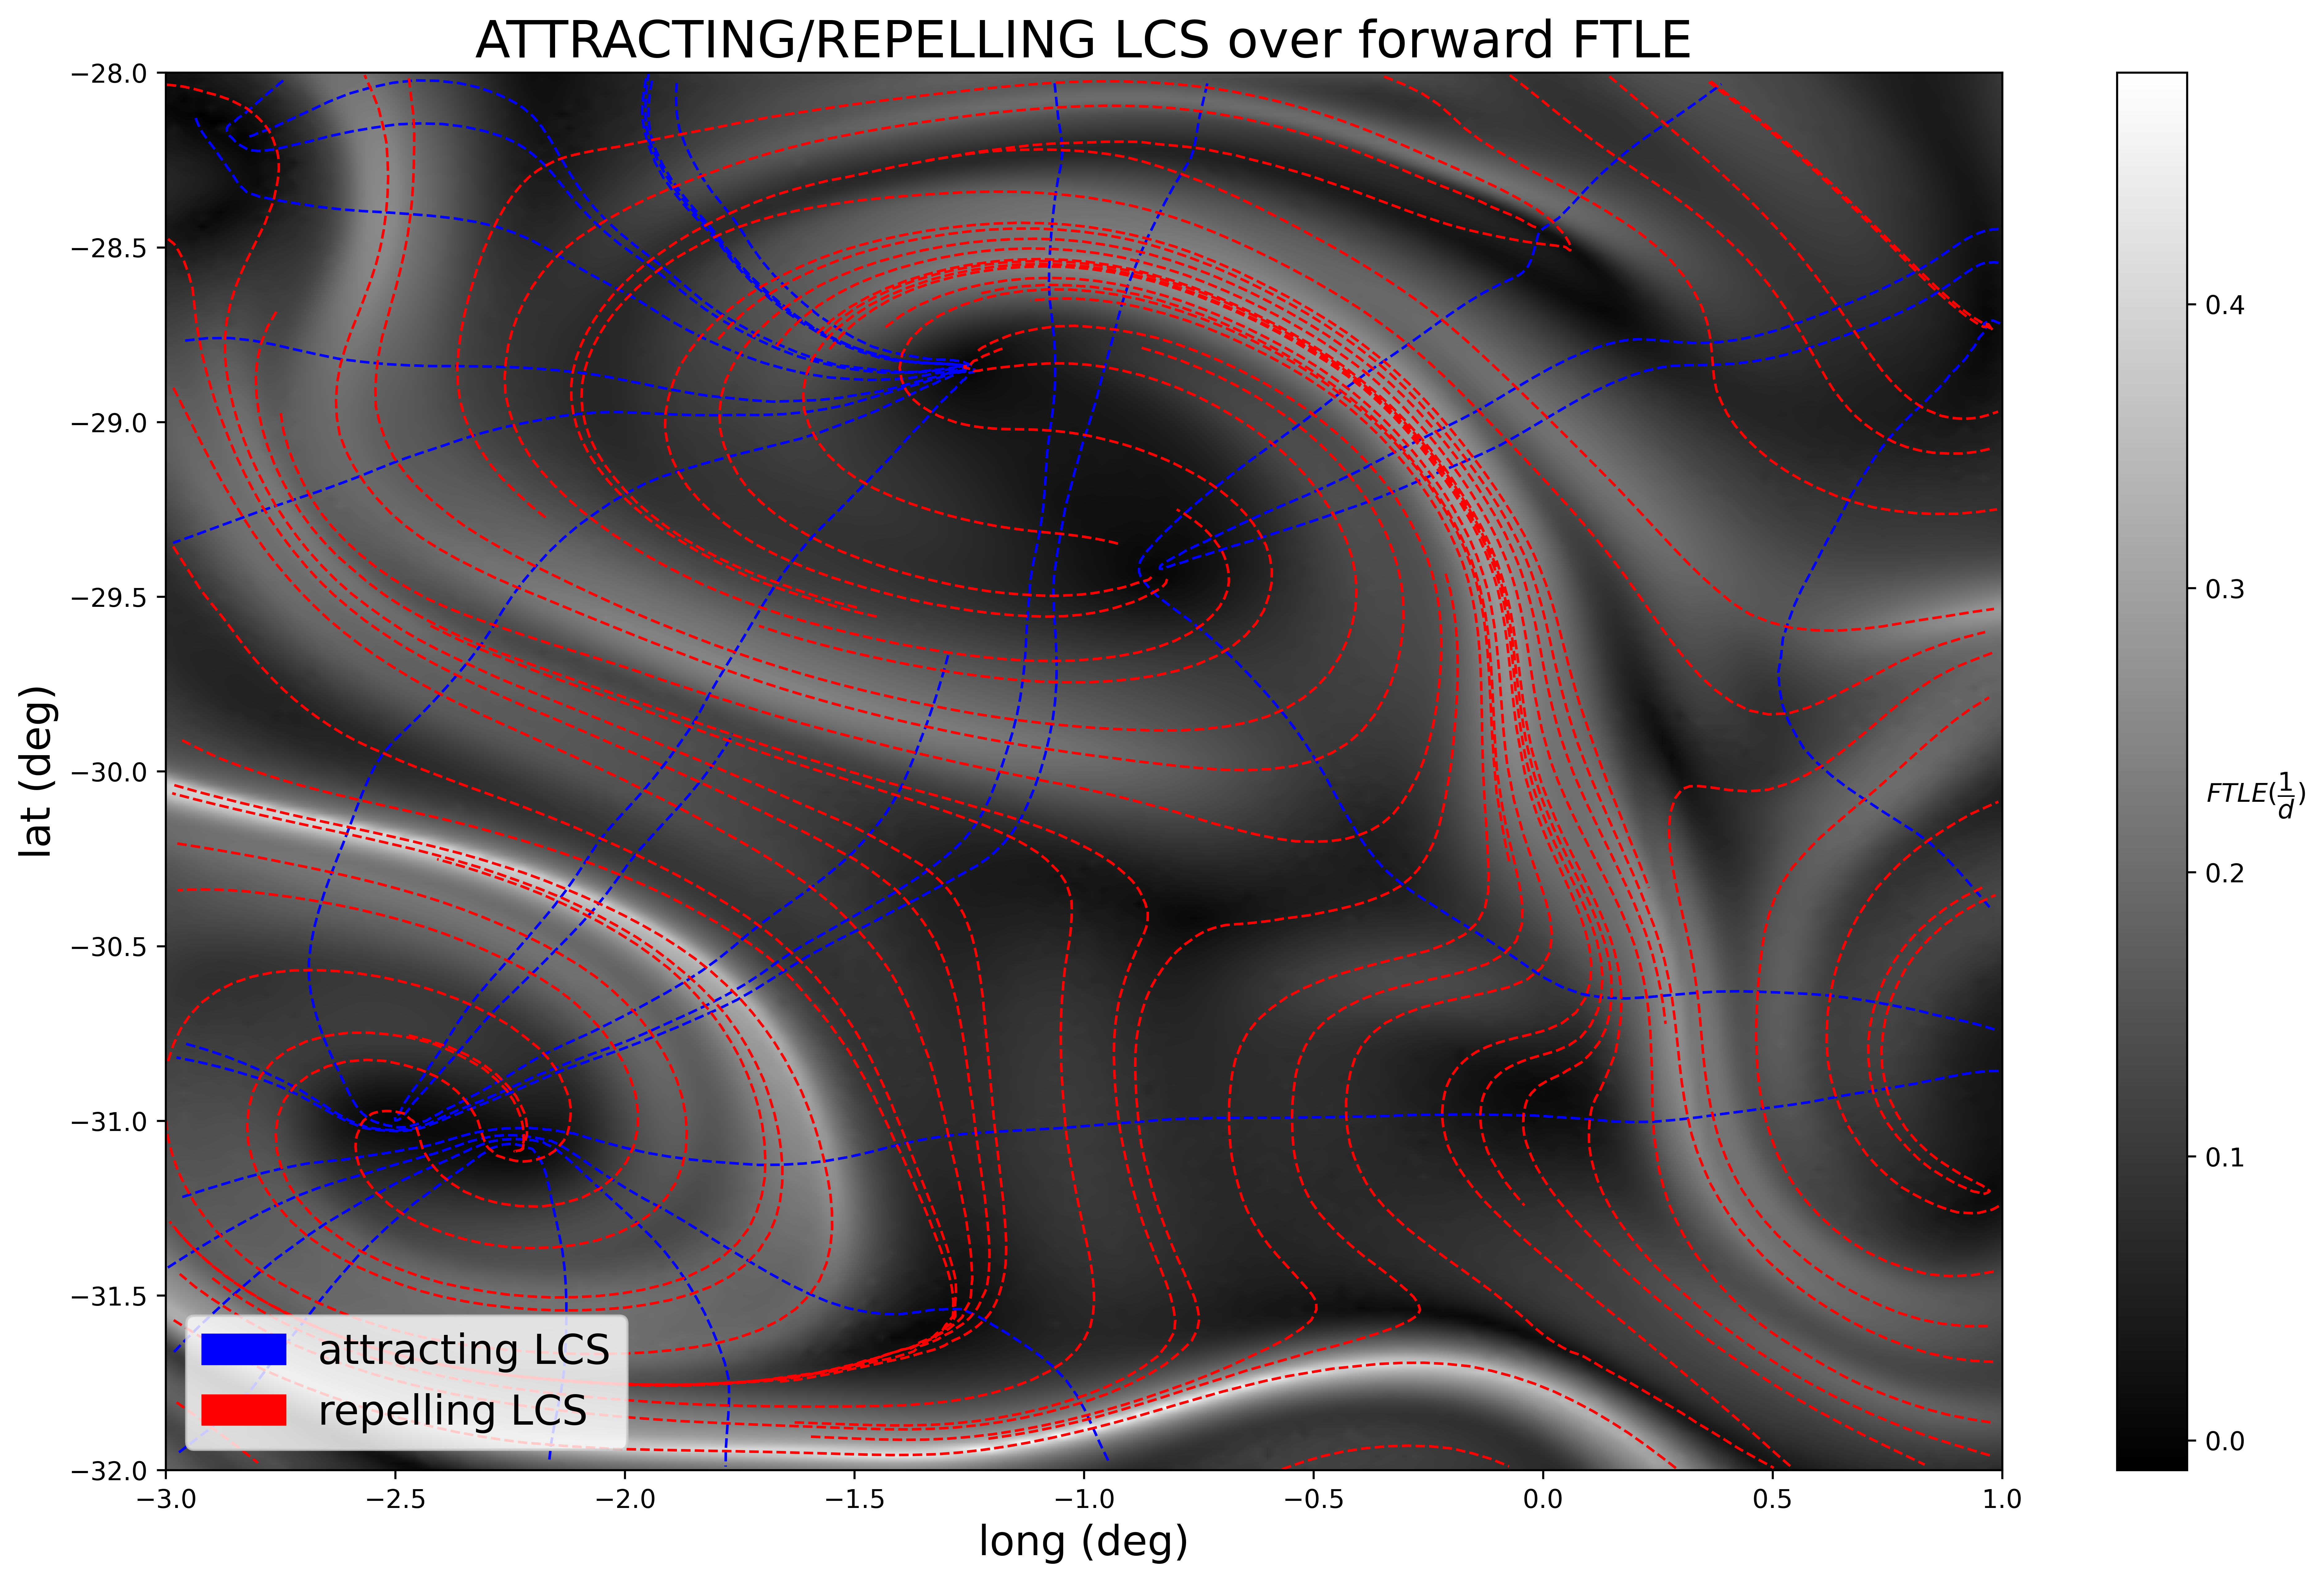

In [13]:
###################################### PLOT REPELLING/ATTRACTING LCS ######################################
import matplotlib.pyplot as plt

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 600)
ax = plt.axes()

for i in range(len(stretchlines[0])):
    ax.plot(stretchlines[0][i], stretchlines[1][i], c = 'b', linewidth = 1, linestyle = "dashed")
    
for i in range(len(shrinklines[0])):
    ax.plot(shrinklines[0][i], shrinklines[1][i], c = 'r', linewidth = 1, linestyle = "dashed")
    
# add FTLE field to plot
cax = ax.contourf(X_domain, Y_domain, np.log(eig2)/lenT, levels = 400, cmap = "gist_gray")    

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(0, 1, 0.1))
cbar.ax.set_ylabel(r'$ FTLE (\dfrac{1}{d}) $', rotation = 0, fontsize = 10)

# Plot legend
import matplotlib.patches as mpatches
attracting = mpatches.Patch(color='b', label='attracting LCS')
repelling = mpatches.Patch(color='r', label='repelling LCS')
plt.legend(handles=[attracting, repelling], fontsize = 16,  loc = "lower left")

# Title
ax.set_title("ATTRACTING/REPELLING LCS over forward FTLE", fontsize = 20)
plt.show();